In [1]:
import crowdsource

In [2]:
import regions

In [3]:
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [5]:
from astropy.io import fits

In [6]:
from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

In [7]:
from astroquery.svo_fps import SvoFps

In [8]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [21]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
im1 = fh
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']

wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
obsdate = im1[0].header['DATE-OBS']

In [18]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [19]:
import numpy as np

In [20]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = filt
nrc.detector = 'NRCA5' # I think NRCA5 must be the "long" detector?
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (68

In [13]:
yy, xx = np.indices([31,31], dtype=float)
grid.x_0 = grid.y_0 = 15.5
psf_model = crowdsource.psf.SimplePSF(stamp=grid(xx,yy))

In [27]:
data = im1['SCI'].data
data = fits.getdata(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_nrca.fits')
err = im1['ERR'].data
wht = weight = im1['WHT'].data

In [23]:
np.nanpercentile(err**-1, 95)

/scratch/local/45915091/ipykernel_24269/2016643170.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  np.nanpercentile(err**-1, 95)


13.61105403900146

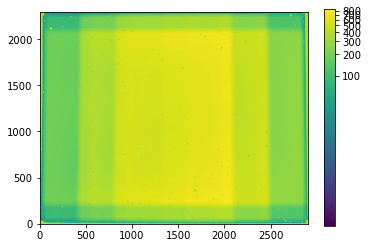

In [33]:
pl.imshow(weight, norm=simple_norm(weight, stretch='log')); pl.colorbar();

In [31]:
ww = wcs.WCS(im1[1].header)
cen = ww.pixel_to_world(im1[1].shape[1]/2, im1[1].shape[0]/2) 
reg = regions.RectangleSkyRegion(center=cen, width=0.5*u.arcmin, height=0.5*u.arcmin)
preg = reg.to_pixel(ww)
mask = preg.to_mask()
slcs,_ = mask.get_overlap_slices(data.shape)
#cutout = mask.cutout(im1[1].data)
#errcutout = mask.cutout(im1[2].data)
#weight = errcutout**-1
#weight[errcutout < 1e-5] = 0
#weight[errcutout == 0] = np.nanmedian(weight)
#weight.max()
#weight[weight > 10] = 10
#weight[weight < 1] = 1
#weight = mask.cutout(im1[('WHT', 1)].data)
#data=cutout
#data.shape

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/scratch/local/45915091/ipykernel_24269/3550161242.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  im = pl.subplot(1,3,3).imshow((err**-1)[slcs], norm=simple_norm(err[slcs]**-1, min_percent=1, max_percent=99, stretch='asinh'))


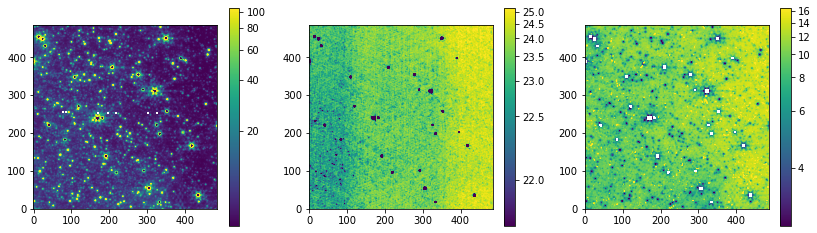

In [46]:
pl.figure(figsize=(14,4))
im = pl.subplot(1,3,1).imshow(data[slcs], norm=simple_norm(data[slcs], min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)
im = pl.subplot(1,3,2).imshow((weight**0.5)[slcs], norm=simple_norm(weight[slcs]**0.5, min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)
im = pl.subplot(1,3,3).imshow((err**-1)[slcs], norm=simple_norm(err[slcs]**-1, min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)

In [51]:
np.any(np.isnan(data[slcs]))

True

In [52]:
# crowdsource uses inverse-error weighting
results_unweighted  = fit_im(np.nan_to_num(data[slcs]), psf_model, weight=np.ones_like(data[slcs])*np.nanmedian(weight)**0.5,
                             #psfderiv=np.gradient(-psf_initial[0].data),
                             nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_unweighted

Extension None, iteration  1, found   3346 sources;    1 close and  595 faint sources removed.
Extension None, iteration  2, found   1262 sources;   17 close and  847 faint sources removed.
Extension None, iteration  3, found   3892 sources;  103 close and  185 faint sources removed.
Extension None, iteration  4, found   3521 sources;  225 close and  289 faint sources removed.
Extension None, iteration  5, found   2423 sources;  346 close and  337 faint sources removed.
Extension None, iteration  6, found   1570 sources;  443 close and  460 faint sources removed.
Extension None, iteration  7, found   1309 sources;  415 close and  449 faint sources removed.
Extension None, iteration  8, found   1419 sources;  438 close and  451 faint sources removed.
Extension None, iteration  9, found   1121 sources;  518 close and  568 faint sources removed.
Extension None, iteration 10, found   1007 sources;  459 close and  417 faint sources removed.


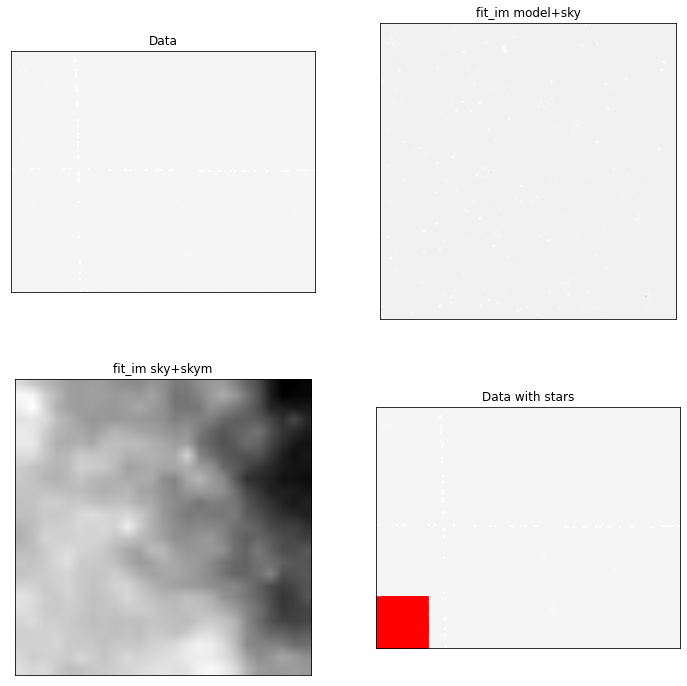

In [53]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

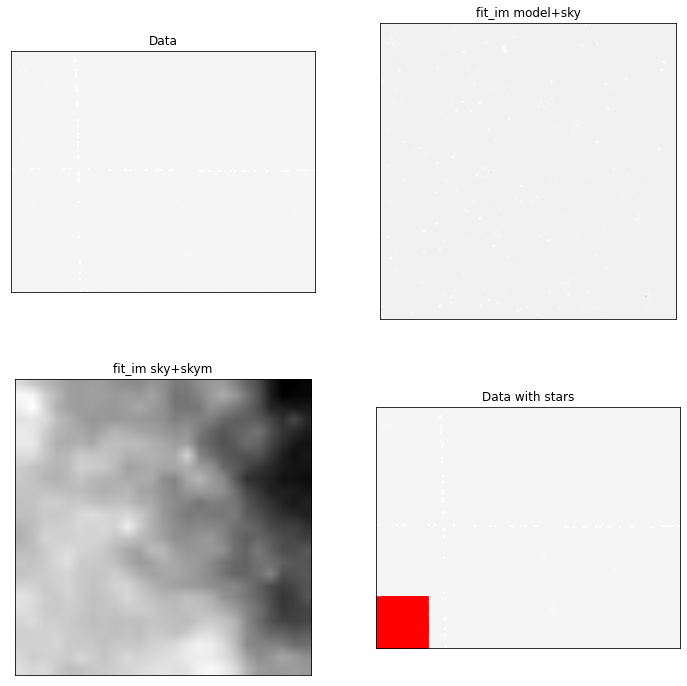

In [54]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

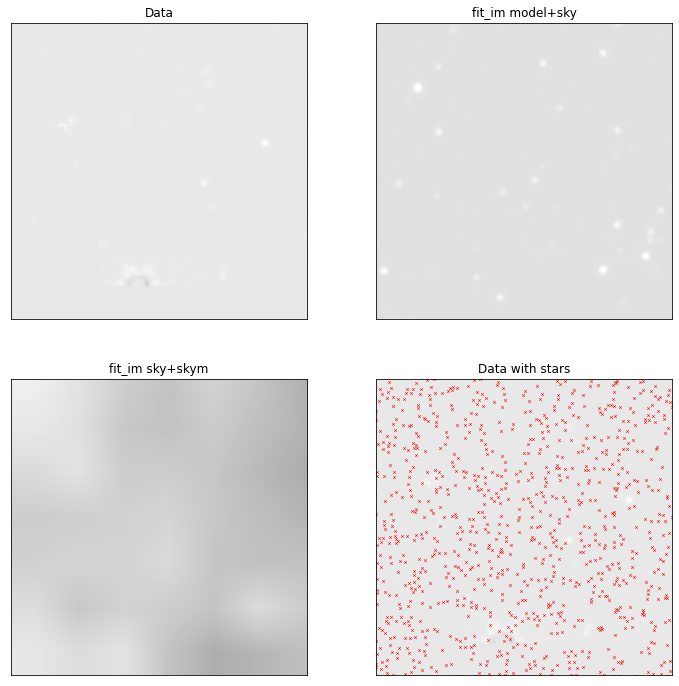

In [55]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky[:128,:128], norm=simple_norm(skymsky[:256,:256], stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

Text(0.5, 1.0, 'Fitted model')

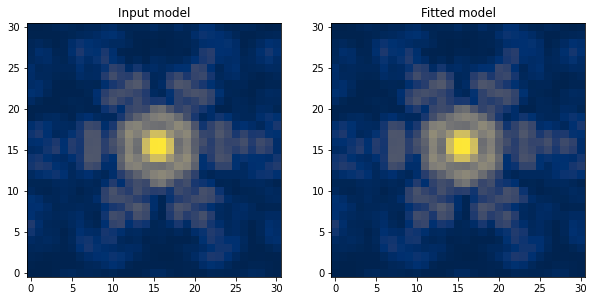

In [56]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input model")
pl.subplot(1,2,2).imshow(psf(30,30), norm=simple_norm(psf(30,30), stretch='log'), cmap='cividis')
pl.title("Fitted model")

ValueError: operands could not be broadcast together with shapes (2297,2901) (486,486) 

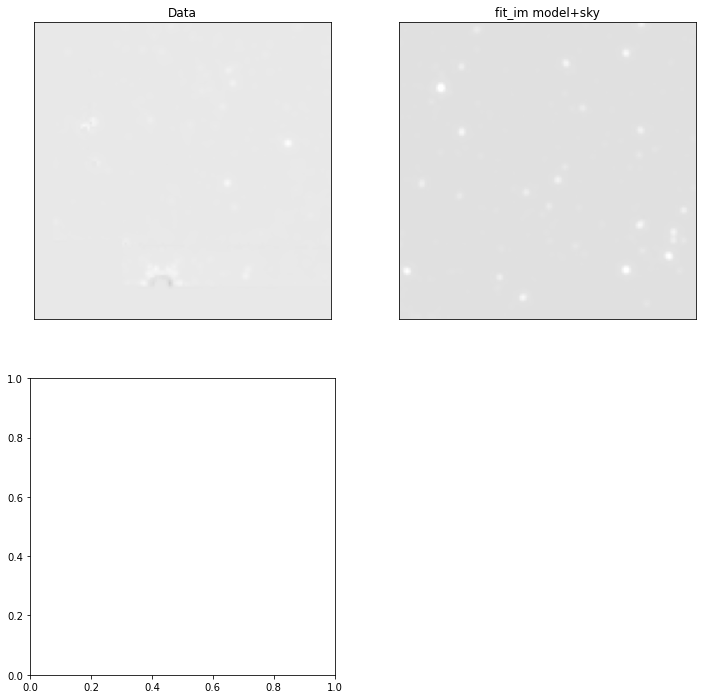

In [57]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

In [ ]:
yy, xx = np.indices([61,61], dtype=float)
grid.x_0 = preg.center.x+30
grid.y_0 = preg.center.y+30
gpsf2 = grid(xx+preg.center.x, yy+preg.center.y)
psf_model = crowdsource.psf.SimplePSF(stamp=gpsf2)
gpsf3 = convolve(gpsf2, Gaussian2DKernel(0.55))
psf_model_blur = crowdsource.psf.SimplePSF(stamp=gpsf3)

/scratch/local/45915091/ipykernel_24269/3550161242.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  im = pl.subplot(1,3,3).imshow((err**-1)[slcs], norm=simple_norm(err[slcs]**-1, min_percent=1, max_percent=99, stretch='asinh'))


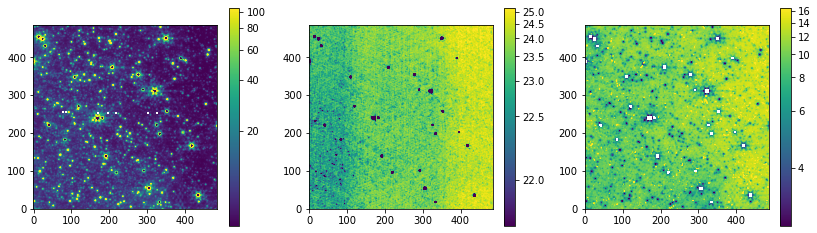

In [46]:
pl.figure(figsize=(14,4))
im = pl.subplot(1,3,1).imshow(data[slcs], norm=simple_norm(data[slcs], min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)
im = pl.subplot(1,3,2).imshow((weight**0.5)[slcs], norm=simple_norm(weight[slcs]**0.5, min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)
im = pl.subplot(1,3,3).imshow((err**-1)[slcs], norm=simple_norm(err[slcs]**-1, min_percent=1, max_percent=99, stretch='asinh'))
pl.colorbar(mappable=im)

In [ ]:
results_blur  = fit_im(np.nan_to_num(data[slcs]), psf_model_blur, weight=np.nan_to_num(weight[slcs]**0.5),
                       nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_blur
fits.BinTableHDU(data=stars).writeto(f"{basepath}/F410M/f410_nrca_crowdsource.fits", overwrite=True)
fits.PrimaryHDU(data=skymsky, header=im1[1].header).writeto(f"{basepath}/F410M/f410_nrca_crowdsource_skymodel.fits", overwrite=True)

In [ ]:
stars, modsky, skymsky, psf = results_blur
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model blurred a little")
pl.tight_layout()

In [ ]:
pl.figure(figsize=(12,12))
pl.imshow(skymsky, cmap='gray', norm=simple_norm(skymsky, stretch='linear'))

In [ ]:
pl.hist(Table(stars)['flux'], bins=np.logspace(1,5))
pl.semilogx()

In [ ]:
stars_unweighted, _, _, _ = results_unweighted
pl.hist(Table(stars)['flux'], bins=np.logspace(1,5))
pl.semilogx()

In [ ]:
stars_b = fits.getdata(f"{basepath}/F410M/f410m_nrca_crowdsource.fits")
ww_b = wcs.WCS(fits.getheader(f"{basepath}/F410M/f410m_nrca_crowdsource_skymodel.fits"))

In [ ]:
slcs, _ = mask.get_overlap_slices(im1[1].data.shape)
wwco = ww[slcs]

In [ ]:
pl.figure(figsize=(12,12))
crdsa = wwco.pixel_to_world(stars['y'], stars['x'])
crdsb = ww_b.pixel_to_world(stars_b['y'], stars_b['x'])
pl.scatter(crdsa.ra, crdsa.dec, marker='x', color='r', s=8, linewidth=0.5)
pl.scatter(crdsb.ra, crdsb.dec, marker='+', color='b', s=8, linewidth=0.5)
pl.axis((266.53,266.542,-28.742,-28.732))